In [125]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import function as fn
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import warnings

In [126]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
seed = 42
warnings.filterwarnings('ignore')

In [127]:
train_data = train_data[['id','Gender', 'Age',
       'Working Professional or Student', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression']]

In [128]:
encoder = LabelEncoder()
train_data['Gender'] = encoder.fit_transform(train_data['Gender'])
train_data['Have you ever had suicidal thoughts ?'] = train_data['Have you ever had suicidal thoughts ?'].map({'Yes': 1, 'No': 0})
train_data['Family History of Mental Illness'] = train_data['Family History of Mental Illness'].map({'Yes': 1, 'No': 0})
train_data['Working Professional or Student'] = train_data['Working Professional or Student'].map({'Working Professional': 1, 'Student': 0})
train_data['Dietary Habits'] = encoder.fit_transform(train_data['Dietary Habits'])
train_data['Sleep Duration'] = encoder.fit_transform(train_data['Sleep Duration'])

In [129]:
train_data['CGPA'].fillna(train_data['CGPA'].mean(), inplace=True)
train_data['Work Pressure'].fillna(0, inplace=True)
train_data['Academic Pressure'].fillna(0, inplace=True)  # Assuming no pressure if missing
#train_data['Working Professional or Student'].fillna("unknown", inplace=True)
train_data['Study Satisfaction'].fillna(0, inplace=True)    
train_data['Financial Stress'].fillna(0, inplace=True)
train_data['Job Satisfaction'].fillna(0, inplace=True)

In [130]:
train_data.head()

,id,Gender,Age,Working Professional or Student,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,0,49.0,1,0.0,5.0,7.658636,0.0,2.0,29,7,0,1.0,2.0,0,0
1,1,1,26.0,1,0.0,4.0,7.658636,0.0,3.0,27,20,1,7.0,3.0,0,1
2,2,1,33.0,0,5.0,0.0,8.970000,2.0,0.0,15,7,1,3.0,1.0,0,1
3,3,1,22.0,1,0.0,5.0,7.658636,0.0,1.0,27,15,1,10.0,1.0,1,1
4,4,0,30.0,1,0.0,1.0,7.658636,0.0,1.0,15,20,1,9.0,4.0,1,0


In [131]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 16 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Gender                                 140700 non-null  int32  
 2   Age                                    140700 non-null  float64
 3   Working Professional or Student        140700 non-null  int64  
 4   Academic Pressure                      140700 non-null  float64
 5   Work Pressure                          140700 non-null  float64
 6   CGPA                                   140700 non-null  float64
 7   Study Satisfaction                     140700 non-null  float64
 8   Job Satisfaction                       140700 non-null  float64
 9   Sleep Duration                         140700 non-null  int32  
 10  Dietary Habits                         140700 non-null  

In [132]:
train_data.isnull().sum()

id                                       0
Gender                                   0
Age                                      0
Working Professional or Student          0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [133]:
train_data.describe()

,id,Gender,Age,Working Professional or Student,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
count,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000
mean,70349.500000,0.550561,40.388621,0.801699,0.623028,2.403930,7.658636,0.583902,2.384385,22.614606,14.098507,0.494399,6.252679,2.988898,0.497100,0.181713
std,40616.735775,0.497439,12.384099,0.398722,1.395493,1.736255,0.652098,1.321153,1.736185,5.617567,5.269147,0.499970,3.853615,1.413703,0.499993,0.385609
min,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,5.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35174.750000,0.000000,29.000000,1.000000,0.000000,1.000000,7.658636,0.000000,1.000000,19.000000,7.000000,0.000000,3.000000,2.000000,0.000000,0.000000
50%,70349.500000,1.000000,42.000000,1.000000,0.000000,2.000000,7.658636,0.000000,2.000000,27.000000,15.000000,0.000000,6.000000,3.000000,0.000000,0.000000
75%,105524.250000,1.000000,51.000000,1.000000,0.000000,4.000000,7.658636,0.000000,4.000000,27.000000,20.000000,1.000000,10.000000,4.000000,1.000000,0.000000
max,140699.000000,1.000000,60.000000,1.000000,5.000000,5.000000,10.000000,5.000000,5.000000,35.000000,23.000000,1.000000,12.000000,5.000000,1.000000,1.000000


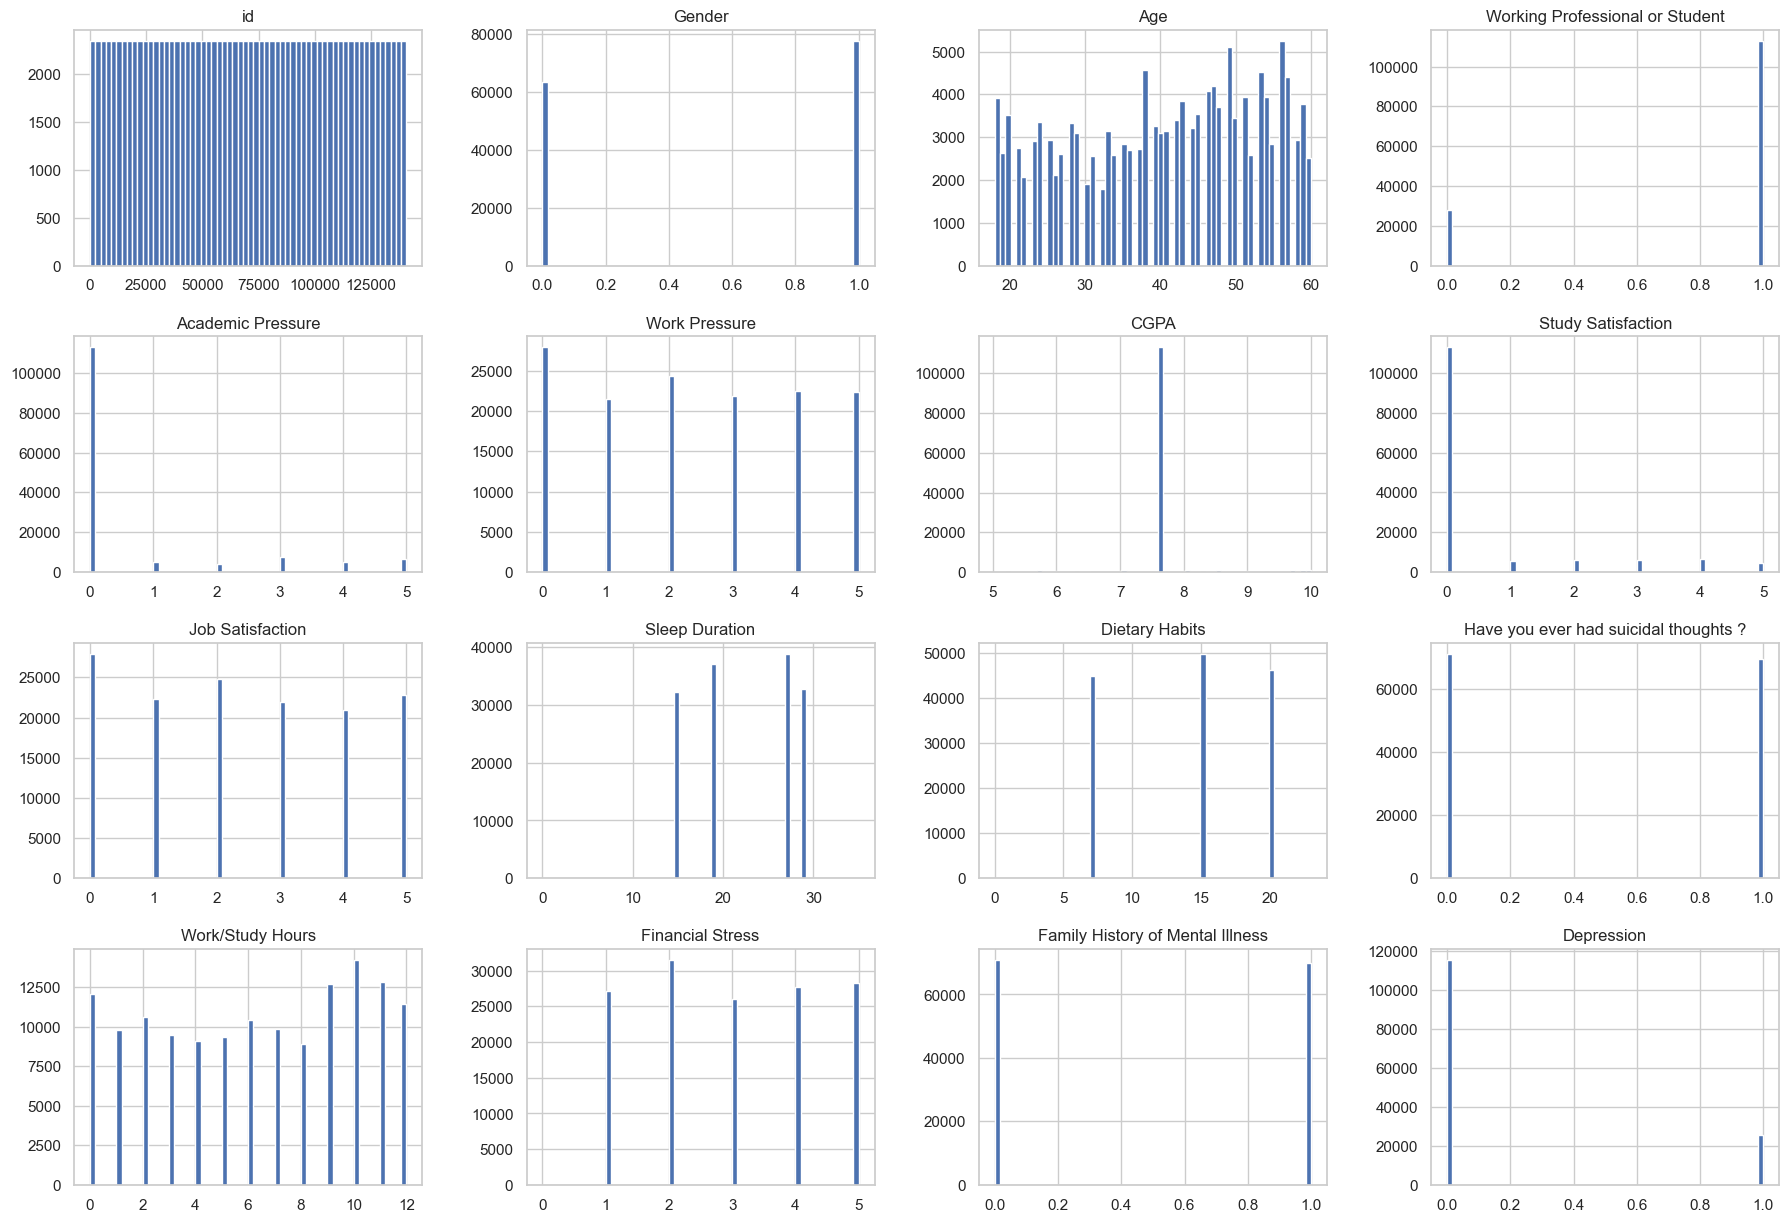

In [134]:
#train data is cleaned now lets do some eda steps to how the data is
train_data.hist(bins=60, figsize=(22,15))
plt.show()

In [135]:
train_data.columns

Index(['id', 'Gender', 'Age', 'Working Professional or Student',
       'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction',
       'Job Satisfaction', 'Sleep Duration', 'Dietary Habits',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [137]:
from sklearn.preprocessing import MinMaxScaler
columns_to_combine = ['Age', 'Work/Study Hours', 'Financial Stress']

# Normalize the columns
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(train_data[columns_to_combine])

train_data['Combined_Stress_Feature'] = scaled_features.mean(axis=1)

In [138]:
train_data

,id,Gender,Age,Working Professional or Student,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Combined_Stress_Feature
0,0,0,49.0,1,0.0,5.0,7.658636,0.0,2.0,29,7,0,1.0,2.0,0,0,0.407143
1,1,1,26.0,1,0.0,4.0,7.658636,0.0,3.0,27,20,1,7.0,3.0,0,1,0.457937
2,2,1,33.0,0,5.0,0.0,8.970000,2.0,0.0,15,7,1,3.0,1.0,0,1,0.269048
3,3,1,22.0,1,0.0,5.0,7.658636,0.0,1.0,27,15,1,10.0,1.0,1,1,0.376190
4,4,0,30.0,1,0.0,1.0,7.658636,0.0,1.0,15,20,1,9.0,4.0,1,0,0.611905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,140695,0,18.0,1,0.0,5.0,7.658636,0.0,4.0,15,20,0,2.0,4.0,1,1,0.322222
140696,140696,0,41.0,1,0.0,5.0,7.658636,0.0,4.0,19,15,1,6.0,5.0,1,0,0.682540
140697,140697,0,24.0,1,0.0,3.0,7.658636,0.0,1.0,29,15,0,4.0,4.0,0,0,0.425397
140698,140698,0,49.0,1,0.0,5.0,7.658636,0.0,2.0,15,15,1,10.0,1.0,0,0,0.590476


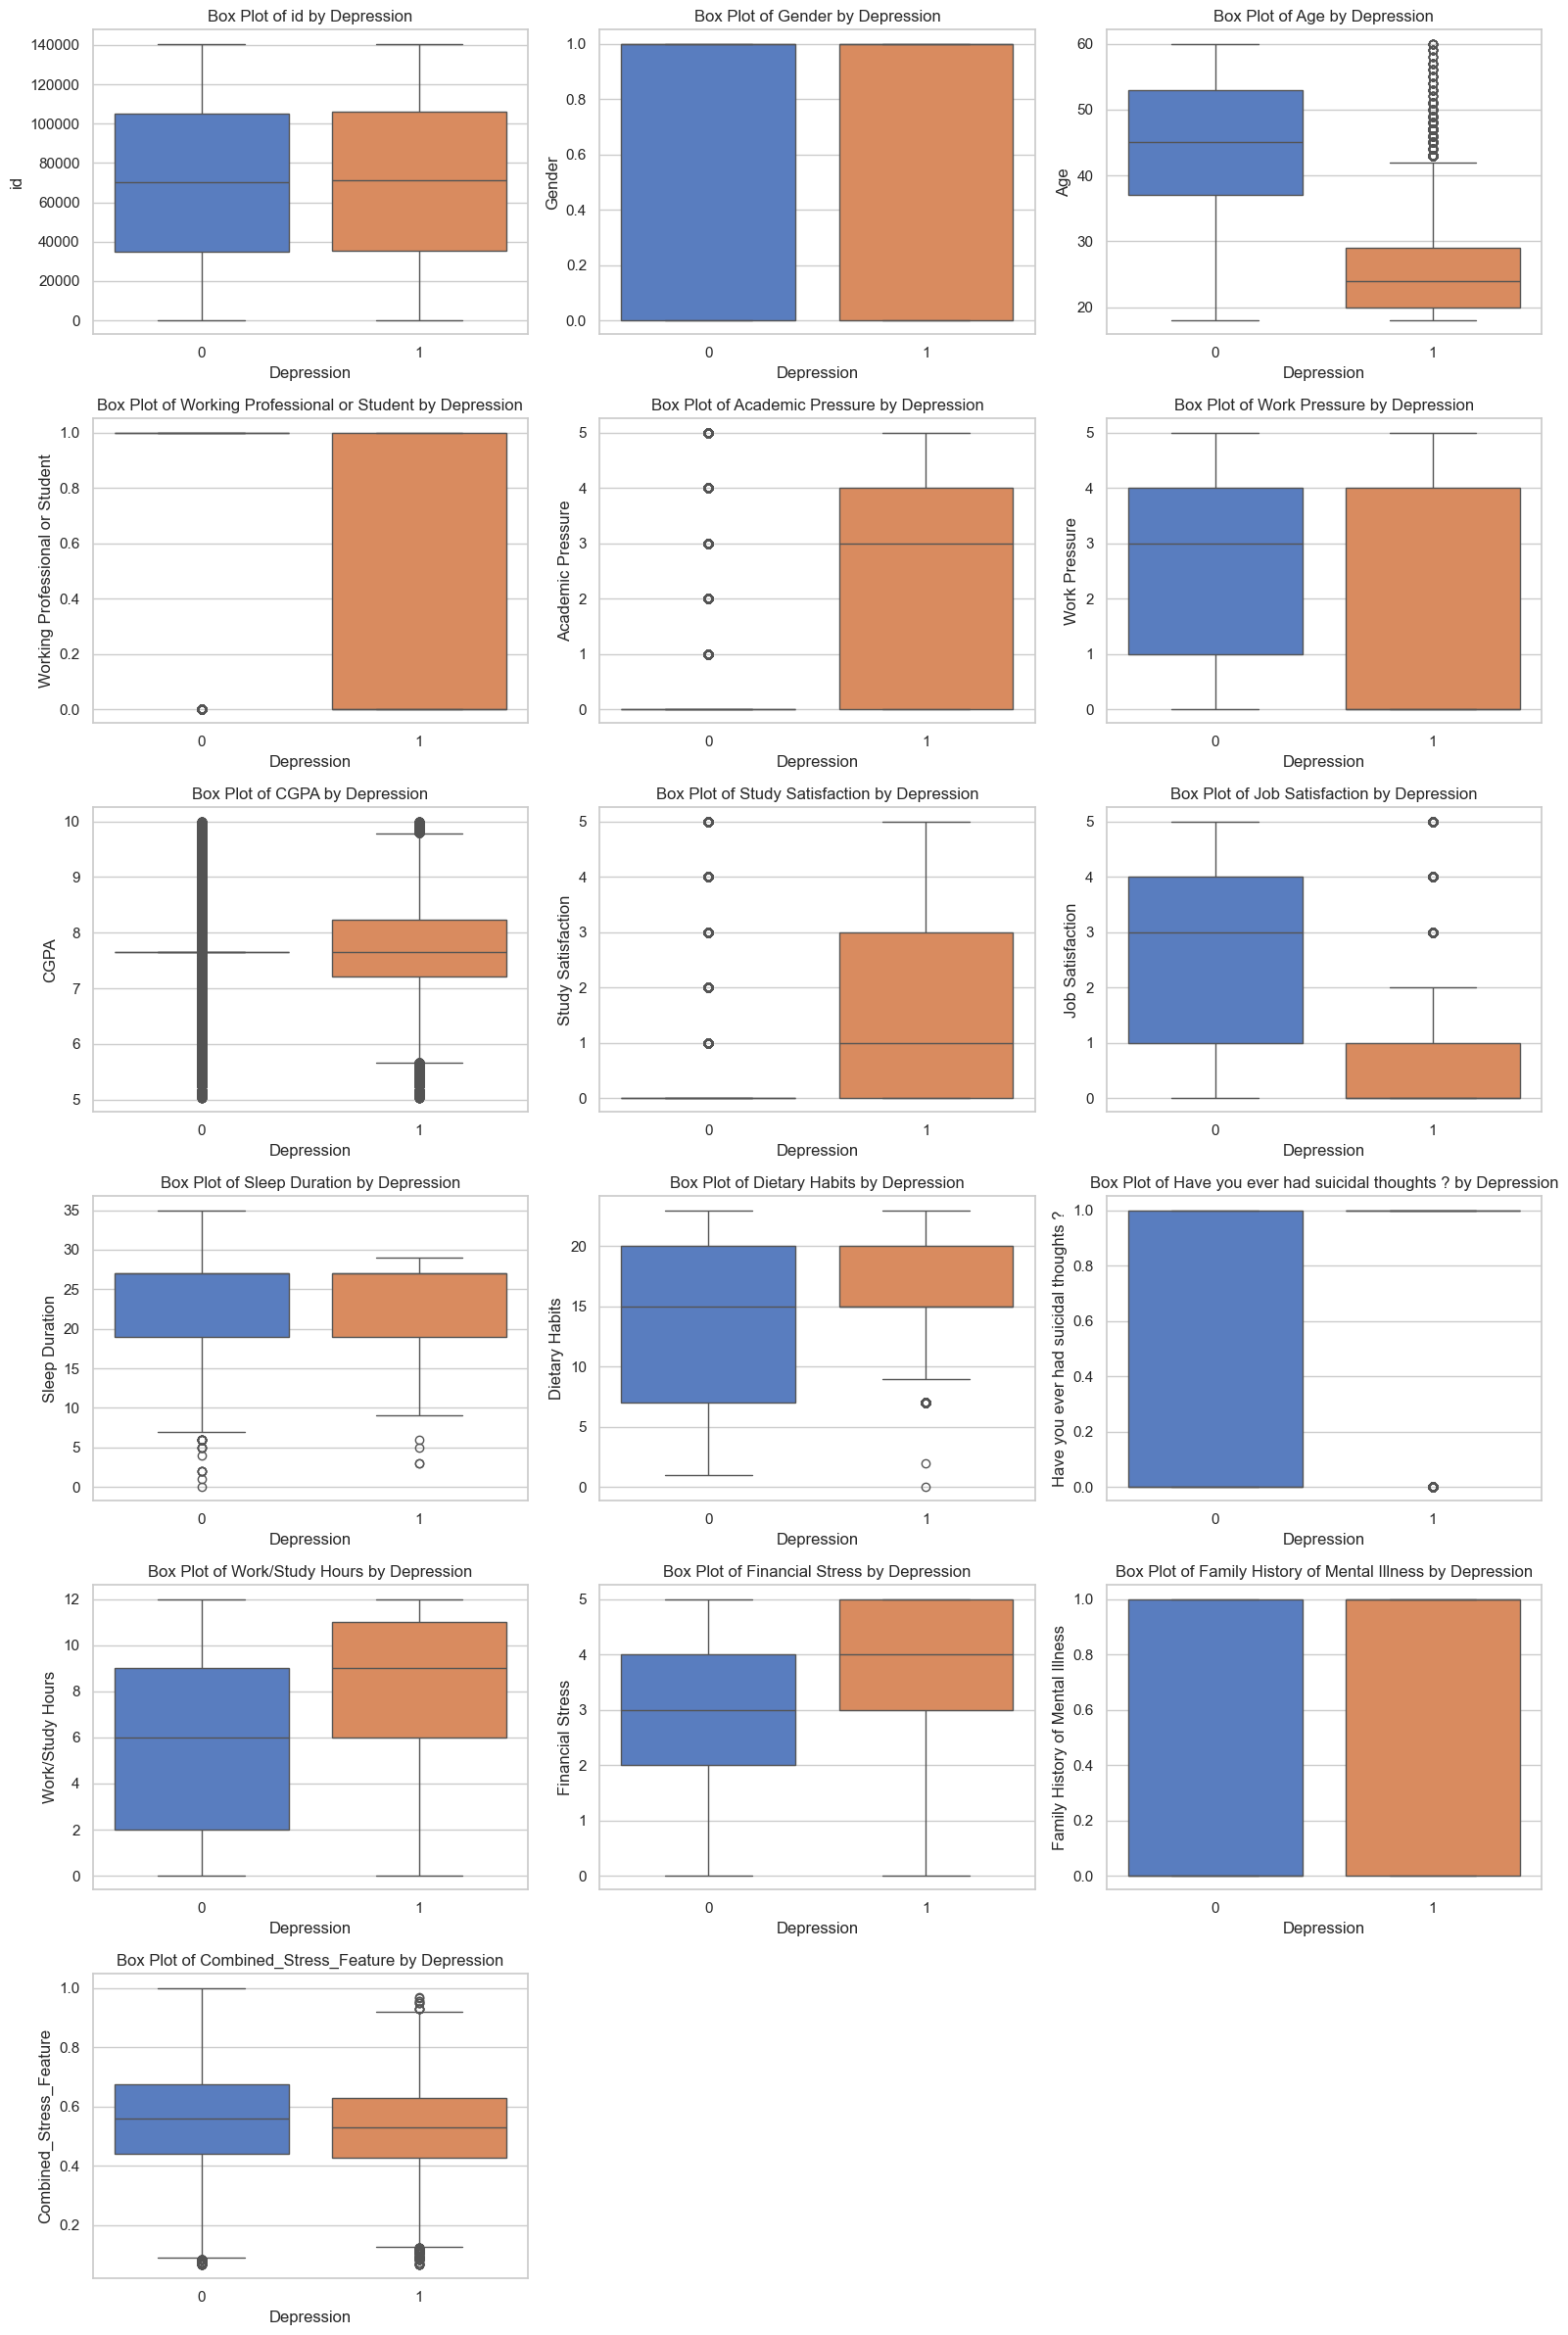

In [139]:
# Select numerical features to visualize (excluding target column 'Depression')
features = [col for col in train_data.columns if col != "Depression"]

# Set up the FacetGrid
n_cols = 3  # Number of columns in the grid
n_rows = -(-len(features) // n_cols)  # Ceiling division to determine rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows), sharey=False)
axes = axes.flatten()  # Flatten axes for easy iteration

for i, column in enumerate(features):
    sns.boxplot(data=train_data, x="Depression", y=column, palette="muted", ax=axes[i])
    axes[i].set_title(f"Box Plot of {column} by Depression")
    axes[i].set_xlabel("Depression")
    axes[i].set_ylabel(column)

# Remove unused subplots if features < n_rows * n_cols
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [143]:
train_data.shape

(140700, 17)

In [144]:
X = train_data.drop(columns=['id','Depression'])
y = train_data['Depression']

In [145]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [146]:
x_train.columns

Index(['Gender', 'Age', 'Working Professional or Student', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness',
       'Combined_Stress_Feature'],
      dtype='object')

In [ ]:
features = ['Age',
       'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction',
       'Job Satisfaction','Dietary Habits',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Combined_Stress_Feature']

In [148]:
x_train1 = x_train[features]
x_test1 = x_test[features]

In [ ]:
model = LGBMClassifier(learning_rate=0.03,num_boost_round=300)
lgbm = model.fit(x_train1, y_train)
pred = lgbm.predict(x_test1)
fn.check_result(y_test, pred)

[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Info] Number of positive: 20413, number of negative: 92147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181352 -> initscore=-1.507213
[LightGBM] [Info] Start training from score -1.507213


{'accuracy': 0.9376332622601279,
 'f1_score': 0.8232450397824554,
 'precision_score': 0.8559162303664921,
 'recall score': 0.7929763290648041,
 'roc_auc_score': 0.8815225332785954}

In [107]:
importances = model.feature_importances_
feature_names = x_train1.columns  # Assuming x_train is a DataFrame
sorted_indices = importances.argsort()[::-1]

for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


Age: 1860.0000
Work/Study Hours: 1255.0000
CGPA: 965.0000
Financial Stress: 945.0000
Work Pressure: 867.0000
Academic Pressure: 801.0000
Job Satisfaction: 731.0000
Dietary Habits: 610.0000
Have you ever had suicidal thoughts ?: 531.0000
Study Satisfaction: 435.0000


In [108]:
def confusion_metrix_plot(y_test, model):
    cm = confusion_matrix(y_test, model)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    plt.show()

In [109]:
y_test.shape

(28140,)

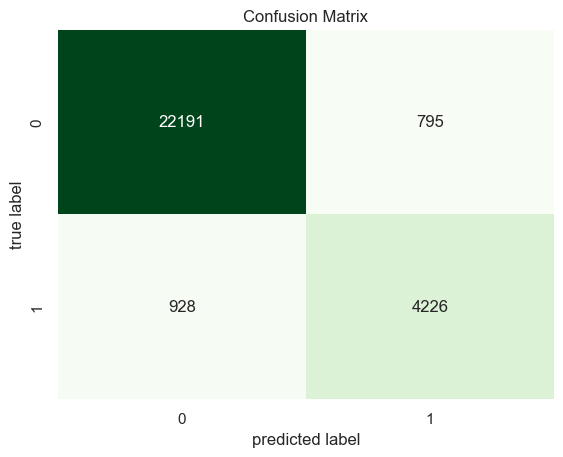

In [110]:
confusion_metrix_plot(y_test, pred) #0:no 1:yes

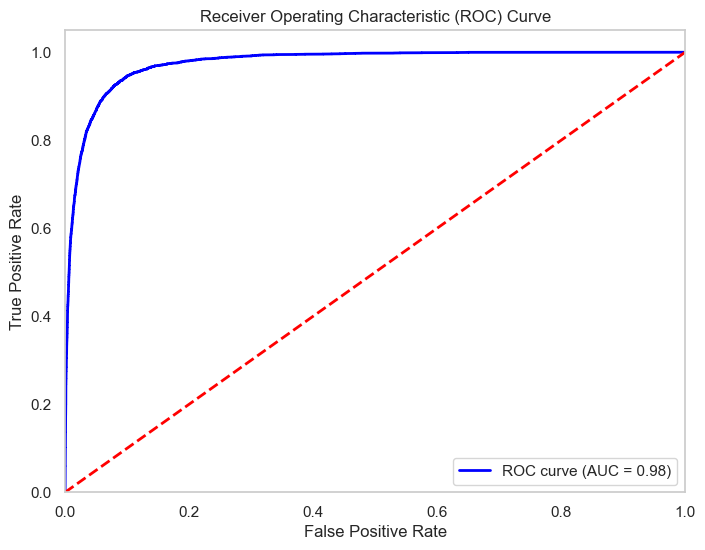

In [111]:
y_prob = lgbm.predict_proba(x_test1)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

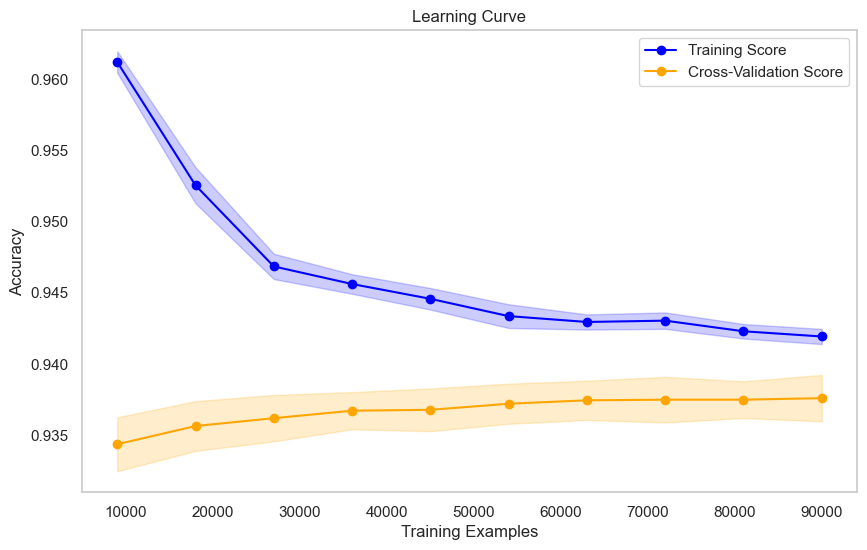

In [73]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(model, X, y, scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Cross-Validation Score')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.2)

    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel(scoring.capitalize())
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Example usage:
plot_learning_curve(model, x_train1, y_train)


In [120]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import pickle

test_data = pd.read_csv("data/test.csv")

test_data = test_data[['id','Gender', 'Age',
       'Working Professional or Student', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness']]

encoder = LabelEncoder()
test_data['Gender'] = encoder.fit_transform(test_data['Gender'])
test_data['Have you ever had suicidal thoughts ?'] = test_data['Have you ever had suicidal thoughts ?'].map({'Yes': 1, 'No': 0})
test_data['Family History of Mental Illness'] = test_data['Family History of Mental Illness'].map({'Yes': 1, 'No': 0})
test_data['Working Professional or Student'] = test_data['Working Professional or Student'].map({'Working Professional': 1, 'Student': 0})
test_data['Dietary Habits'] = encoder.fit_transform(test_data['Dietary Habits'])
test_data['Sleep Duration'] = encoder.fit_transform(test_data['Sleep Duration'])

test_data['CGPA'].fillna(test_data['CGPA'].mean(), inplace=True)
test_data['Work Pressure'].fillna(0, inplace=True)
test_data['Academic Pressure'].fillna(0, inplace=True)  # Assuming no pressure if missing
#test_data['Working Professional or Student'].fillna("unknown", inplace=True)
test_data['Study Satisfaction'].fillna(0, inplace=True)    
test_data['Financial Stress'].fillna(0, inplace=True)
test_data['Job Satisfaction'].fillna(0, inplace=True)

columns_to_combine = ['Age', 'Work/Study Hours', 'Financial Stress']

# Normalize the columns
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(test_data[columns_to_combine])

test_data['Combined_Stress_Feature'] = scaled_features.mean(axis=1)

features = ['Age',
       'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction',
       'Job Satisfaction','Dietary Habits',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress']

data = test_data[features]

In [121]:
data.head()

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress
0,53.0,0.0,2.0,7.674016,0.0,5.0,12,0,9.0,3.0
1,58.0,0.0,2.0,7.674016,0.0,4.0,12,0,6.0,4.0
2,53.0,0.0,4.0,7.674016,0.0,1.0,12,1,12.0,4.0
3,23.0,5.0,0.0,6.840000,1.0,0.0,12,1,10.0,4.0
4,47.0,0.0,5.0,7.674016,0.0,5.0,12,1,3.0,4.0


In [122]:
lgbm_path = "lgbm_model.pkl"
with open(lgbm_path, 'rb') as file:
    lgbm = pickle.load(file)
    
lgbm_pred = lgbm.predict(data)

test_data['Depression'] = lgbm_pred

In [118]:
test_data = test_data[['id', 'Depression']]

In [124]:
test_data.head(15)

,id,Gender,Age,Working Professional or Student,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Combined_Stress_Feature,Depression
0,140700,1,53.0,1,0.0,2.0,7.674016,0.0,5.0,25,12,0,9.0,3.0,1,0.694444,0
1,140701,0,58.0,1,0.0,2.0,7.674016,0.0,4.0,25,12,0,6.0,4.0,0,0.734127,0
2,140702,1,53.0,1,0.0,4.0,7.674016,0.0,1.0,16,12,1,12.0,4.0,0,0.861111,0
3,140703,0,23.0,0,5.0,0.0,6.840000,1.0,0.0,27,12,1,10.0,4.0,0,0.567460,1
4,140704,1,47.0,1,0.0,5.0,7.674016,0.0,5.0,16,12,1,3.0,4.0,0,0.563492,0
5,140705,1,29.0,1,0.0,2.0,7.674016,0.0,3.0,27,12,0,3.0,2.0,1,0.253968,0
6,140706,1,47.0,1,0.0,1.0,7.674016,0.0,1.0,25,5,0,10.0,3.0,1,0.674603,0
7,140707,0,28.0,1,0.0,5.0,7.674016,0.0,3.0,16,5,1,0.0,2.0,0,0.162698,0
8,140708,0,21.0,0,1.0,0.0,7.390000,3.0,0.0,25,5,0,8.0,1.0,1,0.246032,0
9,140709,1,21.0,1,0.0,5.0,7.674016,0.0,1.0,25,5,1,10.0,4.0,0,0.551587,1
